# First Take on Classification: Studying Tools and Data





## KNN and HOG classification: 


In [1]:
import os
import numpy as np
import cv2
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from glob import glob

def summary(array):
    min_val = np.min(array)
    max_val = np.max(array)
    sd = np.std(array)
    var = np.var(array)
    mean = np.mean(array)
    median = np.median(array)
    percentile25 = np.percentile(array, 25)
    percentile50 = np.percentile(array, 50)
    percentile75 = np.percentile(array, 75)
    
    summaryDict = {"max":max_val, 'min':min_val, "mean":mean, "median":median, "SD": sd, 
                   "var":var, "25th":percentile25, "50th": percentile50, "75th":percentile75 }
    return summaryDict

# corn = glob('./corn/train/*.png')
# print(os.getcwd())
# print(os.listdir("./corn/train"))

In [2]:
# determine unique aspect ratios in order to determine consistent resizing: 
corn = glob('./corn/train/*.png')
allShapes = [cv2.imread(img).shape for img in corn]
height = [img[0] for img in allShapes]
width = [img[1] for img in allShapes]
aspectRatios = []

In [3]:
# 2 ways to calculate... prefer the vectorized method as it reads better for me 
for i in range(0, len(allShapes)):
    aspectRatio = width[i] / height[i]
    aspectRatios.append(aspectRatio)

In [4]:
import matplotlib.pyplot as plt

14322
651 
 [0.96875, 1.125, 1.0, 1.0303030303030303, 1.0625, 1.15625, 1.3157894736842106, 0.90625, 1.28125, 0.875, 1.09375, 1.03125, 0.9375, 1.1875, 0.75, 1.5, 0.8275862068965517, 1.0444444444444445, 1.25, 1.21875, 1.3125, 1.34375, 1.40625, 0.8125, 1.4375, 0.84375, 1.375, 0.6875, 1.4814814814814814, 1.4848484848484849, 0.7251461988304093, 0.8260869565217391, 0.9696969696969697, 1.032258064516129, 1.2285714285714286, 1.6206896551724137, 0.7941176470588235, 1.3488372093023255, 1.0074074074074073, 0.7358490566037735, 0.9545454545454546, 0.7045454545454546, 1.5483870967741935, 1.4545454545454546, 1.2045454545454546, 0.6521739130434783, 1.4615384615384615, 0.9407894736842105, 0.9393939393939394, 0.6326530612244898, 1.064516129032258, 1.4705882352941178, 1.0955882352941178, 0.5777777777777777, 1.1818181818181819, 1.088235294117647, 0.725, 0.6, 1.53125, 1.0078125, 0.5, 1.46875, 1.59375, 0.9210526315789473, 1.2265625, 0.78125, 1.0546875, 1.0234375, 1.4242424242424243, 1.0460526315789473, 1.42

{'whiskers': [<matplotlib.lines.Line2D at 0x17a63b8d6f0>,
 'caps': [<matplotlib.lines.Line2D at 0x17a63b8dc30>,
 'boxes': [<matplotlib.lines.Line2D at 0x17a63b8d570>],
 'medians': [<matplotlib.lines.Line2D at 0x17a63b8e170>],
 'fliers': [<matplotlib.lines.Line2D at 0x17a63b8e410>],
 'means': []}

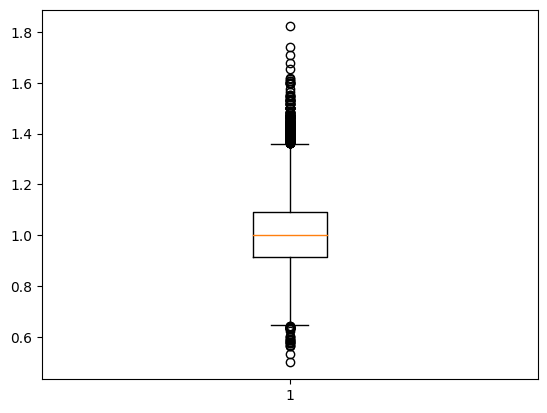

In [5]:
aspect_ratios = np.array(width) / np.array(height)
print(len(aspect_ratios))
uniqueRatios = list(set(aspect_ratios))
print(len(uniqueRatios), "\n", uniqueRatios)
print(summary(uniqueRatios))

plt.boxplot(aspect_ratios)
# this suggests we could segment the data into like 4-5 groups and process separately.. but that seems too complicated. Going to use means to determine treatment

In [6]:
# Determining image size to crop to:
print(summary(height))
print(summary(width))
print(width[:10], height[:10]) # cv2 reads in H x W x Channels, verified by visual inspection 
# considering the mean ratio being about 1, and the means of both means on width and height are similar well roll with 140 for the image sizes 

{'max': 228, 'min': 86, 'mean': 143.75506214215892, 'median': 140.0, 'SD': 19.279141381734032, 'var': 371.68529241688964, '25th': 132.0, '50th': 140.0, '75th': 156.0}
{'max': 224, 'min': 84, 'mean': 143.5453149001536, 'median': 140.0, 'SD': 18.52569687419646, 'var': 343.20144467461245, '25th': 132.0, '50th': 140.0, '75th': 152.0}
[144, 152, 144, 148, 120, 124, 144, 136, 140, 164] [136, 156, 128, 148, 108, 136, 176, 132, 148, 120]


In [7]:
print(os.getcwd())

d:\Programming\Python_code\PrinciplesOfDS_Course\finalProject


In [8]:
# Create directory func, center crop func for preprocessing 
def c_dir(dirPath):
    if not os.path.exists(dirPath):
        os.makedirs(dirPath)

In [9]:
c_dir(os.getcwd() + "/corn/centerCropInspect") # should have used "./corn/... " .. thats where my inital call flubbed 
c_dir(os.getcwd() + "/corn/centerCropInspect_140")
c_dir(os.getcwd() + "/corn/centerCropInspect_110")
c_dir(os.getcwd() + "/corn/centerCropInspect_90")

In [10]:
# center cropping function
def center_crop(img, target_size):
    h, w = img.shape[:2]
    th, tw = target_size

    if h < th or w < tw:
        raise ValueError("Target size should be smaller than the input image size")

    x = (w - tw) // 2
    y = (h - th) // 2
    cropped_img = img[y:y+th, x:x+tw]

    return cropped_img

In [11]:
# test center cropping on a set of images
# crop 100 images, write to a new folder, and then visually inspect 

target_size = (110,110)
croppedImages = []

for imgPth in corn[:1000]:
    temp_img = cv2.imread(imgPth)
    if (temp_img.shape[0] >= target_size[0] & temp_img.shape[1] >= target_size[1] ):
        croppedimg = center_crop(temp_img, target_size)
        croppedImages.append(croppedimg)
    else:
        resizedImg = cv2.resize(temp_img, target_size)
        croppedImages.append(resizedImg)
        
for idx, img in enumerate(croppedImages): # modify path according to target size 
    output_path = "./corn/centerCropInspect_/" + s[0] + f'cropped_or_resized_{idx}.png'
    cv2.imwrite(output_path, img)

# tried target size 140, most images look find at a glance, but not much has been cropped out, would like to see a larger set with a smaller size 

NameError: name 's' is not defined

In [12]:
# testing different sizes 
sizes = [(140,140), (110,110), (90,90)]

for s in sizes:
    
    croppedImages = []
    
    for imgPth in corn[:1000]:
        temp_img = cv2.imread(imgPth)
        if (temp_img.shape[0] >= s[0]) and (temp_img.shape[1] >= s[1]):
            croppedimg = center_crop(temp_img, s)
            croppedImages.append(croppedimg)
        else:
            resizedImg = cv2.resize(temp_img, s)
            croppedImages.append(resizedImg)
            
    for idx, img in enumerate(croppedImages): # modify path according to target size 
        output_path = "./corn/centerCropInspect_" + str(s[0]) + "/" + f'cropped_or_resized_{idx}.png'
        cv2.imwrite(output_path, img)

### Visual Inspection of cropping and resizing: 

Images look best at 140 x 140. Greater detail is evident when up quite close.. but the edges of many kernals are lost, which I wonder if that could be a cause of vital data loss. At the same time, the white space is less present in the 110 image size, and most of the critical details resolvable by vision are preserved. So I think I will try and use both a 110 x 110 size and 140 x 140. 

## Setup image pre-processing function for quick modifications later on: 



In [54]:
# list files 
img_folder = './corn/train/*.png'
corn = glob(img_folder)

# preprocess images: center crop and normalization 
target_size = (140,140)
croppedImages = []

for imgPth in corn:
    temp_img = cv2.imread(imgPth)
    if (temp_img.shape[0] >= target_size[0] & temp_img.shape[1] >= target_size[1]):
        croppedimg = center_crop(temp_img, target_size)
        croppedimg = (croppedimg / 255).astype(np.float32) # normalize
        croppedImages.append(croppedimg)
    else:
        resizedImg = cv2.resize(temp_img, target_size)
        resizedImg = (resizedImg / 255).astype(np.float32) # normalize
        croppedImages.append(resizedImg)

croppedImages_grey = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in croppedImages]

In [56]:
# Greyscale conversion and HOG feature extraction 
croppedImages_grey = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in croppedImages]

hog_features = [hog(img, orientations=9, pixels_per_cell=(8,8), cells_per_block=(2,2)) for img in croppedImages_grey]

In [66]:
# Load in label table: 
import pandas as pd 
train_csv = pd.read_csv("./corn/train.csv")
print(train_csv.head())

labels = train_csv['label']
labels.head()

   seed_id    view            image       label
0        0     top  train/00000.png      broken
1        1  bottom  train/00001.png        pure
2        3     top  train/00003.png      broken
3        4     top  train/00004.png        pure
4        5     top  train/00005.png  discolored


0        broken
1          pure
2        broken
3          pure
4    discolored
Name: label, dtype: object

In [68]:
# split data, train model, make predictions
X_train, X_test, y_train, y_test = train_test_split(hog_features, labels, test_size=0.2, random_state=42)

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)



KNeighborsClassifier(n_neighbors=10)

In [71]:
# evaluate the model: 

# Evaluate the classifier on the test set
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred, digits = 4))

              precision    recall  f1-score   support

      broken    0.75000   0.07492   0.13623       921
  discolored    0.14286   0.00197   0.00389       507
        pure    0.41676   0.99137   0.58682      1159
     silkcut    0.55556   0.01799   0.03484       278

    accuracy                        0.42723      2865
   macro avg    0.46629   0.27156   0.19045      2865
weighted avg    0.48888   0.42723   0.28525      2865



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


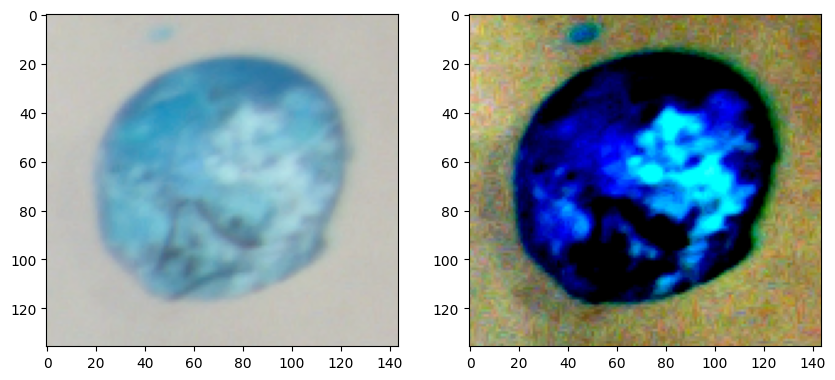

In [14]:
# normalization of a single image: 
corn1 = cv2.imread(corn[0])

corn1_norm = corn1 / 255
corn1_standardized = (corn1 - np.mean(corn1)) / np.std(corn1)

fig, axs = plt.subplots(1,2, figsize=(10,5)) 
axs[0].imshow(corn1_norm)
axs[1].imshow(corn1_standardized)

In [29]:
# preprocess a few images using HOG, visually inspect to build intuition
corn_hogs = [cv2.imread(img) for img in corn[:10]]

# make images greyscale for first go 
corn_hogs_grey = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in corn_hogs]

print(type(corn_hogs_grey[0]), len(corn_hogs_grey))

# Compute HOG features and visualization
hog_data = [hog(grey_corn, orientations=9, pixels_per_cell=(8, 8),
                                      cells_per_block=(2, 2), block_norm='L2-Hys',
                                      visualize=True) for grey_corn in corn_hogs_grey]

hog_features, hog_visualization = zip(*hog_data)

<class 'numpy.ndarray'> 10


In [48]:
# images were resized, want to inspect manually
cornDims = [img.shape for img in corn_hogs]
print(cornDims)
cornDimsGrey = [img.shape for img in corn_hogs_grey]
print(cornDimsGrey)

# the original heights and widths aren't changing here. 
print(type(corn_hogs_grey[1]))

[(136, 144, 3), (156, 152, 3), (128, 144, 3), (148, 148, 3), (108, 120, 3), (136, 124, 3), (176, 144, 3), (132, 136, 3), (148, 140, 3), (120, 164, 3)]
[(136, 144), (156, 152), (128, 144), (148, 148), (108, 120), (136, 124), (176, 144), (132, 136), (148, 140), (120, 164)]
<class 'numpy.ndarray'>


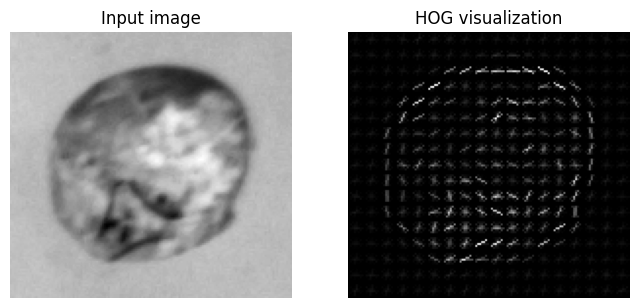

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(corn_hogs_grey[0], cmap=plt.cm.gray)
ax1.set_title('Input image')

ax2.axis('off')
ax2.imshow(hog_visualization[0], cmap=plt.cm.gray)
ax2.set_title('HOG visualization')

plt.show() # no image resizing, so it seems to not be the image itself that is resized. 

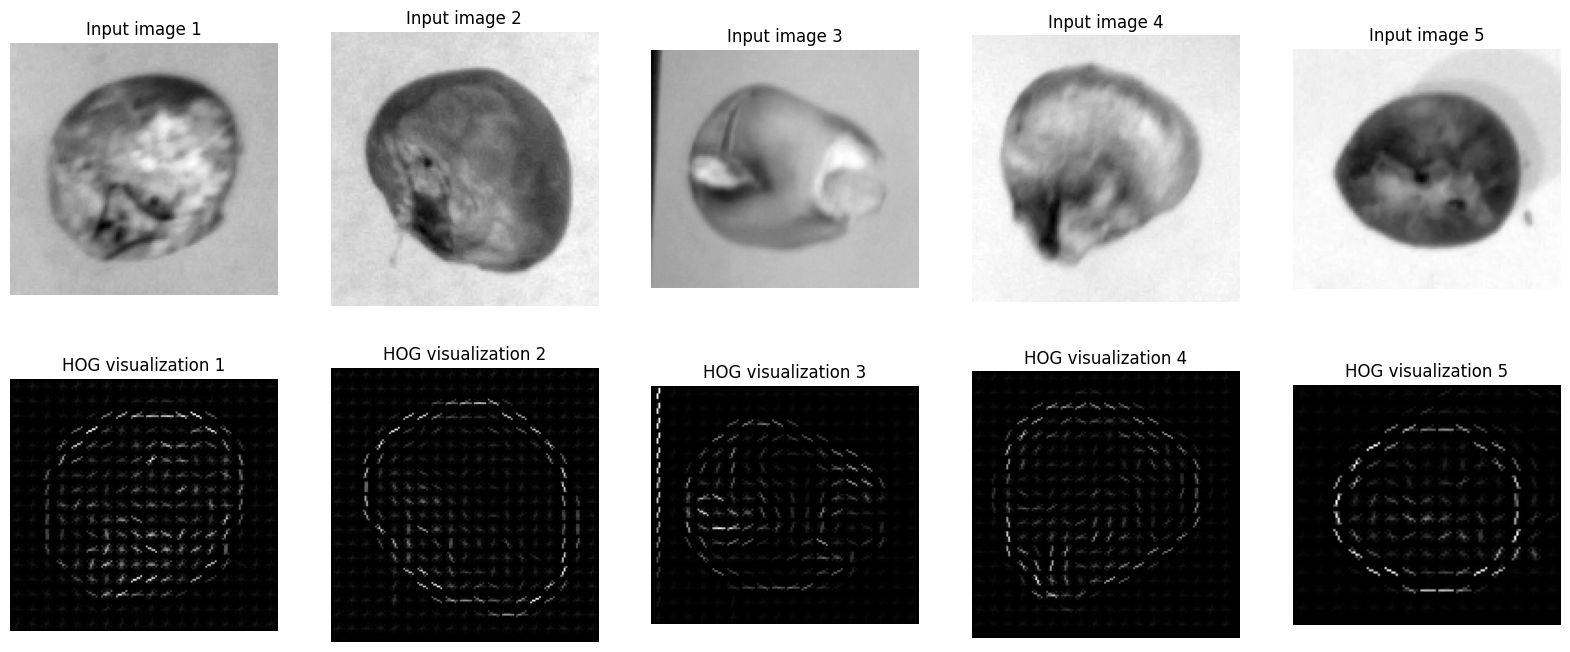

In [45]:
# plot HOG features against original image to learn 
# fig, axes = plt.subplots(2,5, figsize=(20,8), sharex=True, sharey=True)
fig, axes = plt.subplots(2,5, figsize=(20,8)) # this is what we wanted. 

for i in range(5):
    axes[0, i].axis('off')
    axes[0, i].imshow(corn_hogs_grey[i], cmap=plt.cm.gray)
    axes[0, i].set_title(f'Input image {i+1}')

    axes[1, i].axis('off')
    axes[1, i].imshow(hog_visualization[i], cmap=plt.cm.gray)
    axes[1, i].set_title(f'HOG visualization {i+1}')

plt.show()
# "The images may appear truncated if their aspect ratios differ significantly. In this case, the sharex and sharey parameters cause all subplots to share the same x and y limits, which could lead to some images appearing truncated if they don't fit within those limits."

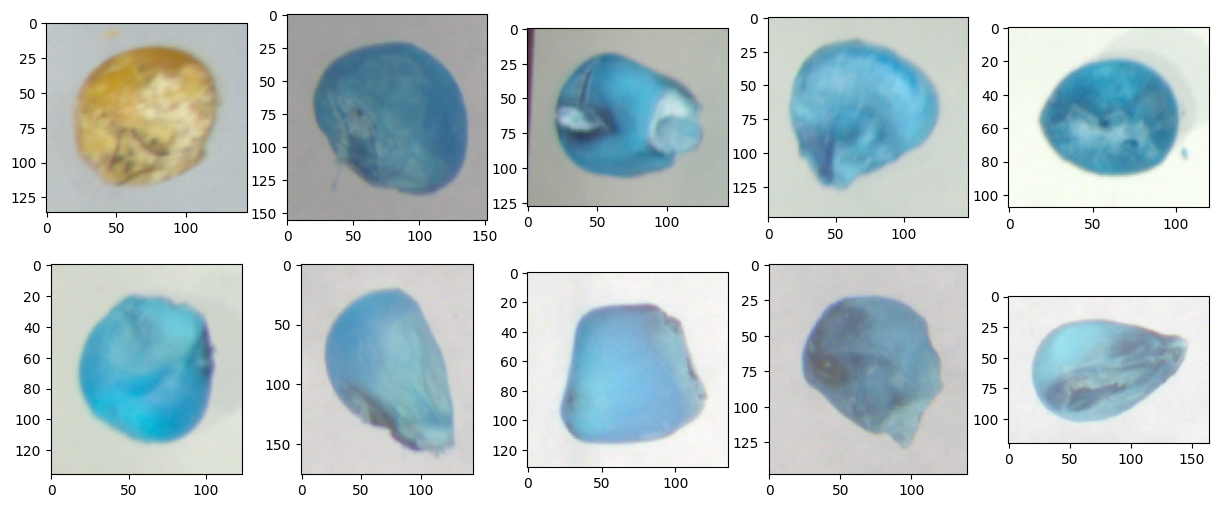

In [39]:
#original images: 
fig, axs = plt.subplots(2,5, figsize=(15,6))
axs[0,0].imshow(cv2.cvtColor(corn_hogs[0], cv2.COLOR_BGR2RGB))
axs[0,1].imshow(corn_hogs[1])
axs[0,2].imshow(corn_hogs[2])
axs[0,3].imshow(corn_hogs[3])
axs[0,4].imshow(corn_hogs[4])
axs[1,0].imshow(corn_hogs[5])
axs[1,1].imshow(corn_hogs[6])
axs[1,2].imshow(corn_hogs[7])
axs[1,3].imshow(corn_hogs[8])
axs[1,4].imshow(corn_hogs[9])
plt.show()

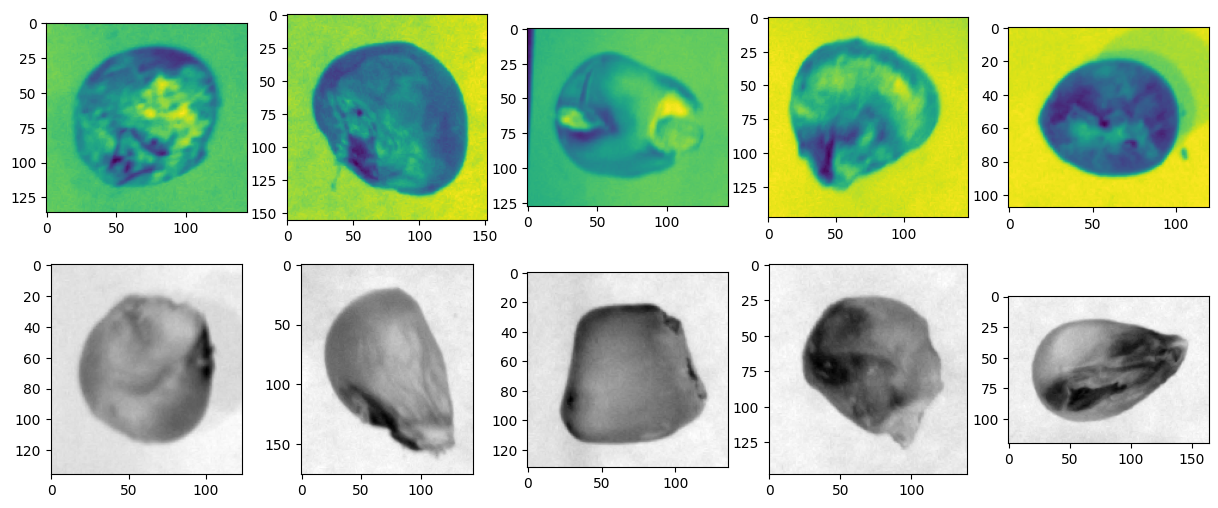

In [38]:
# greyscale versions: 
fig, axs = plt.subplots(2,5, figsize=(15,6))
axs[0,0].imshow(corn_hogs_grey[0])
axs[0,1].imshow(corn_hogs_grey[1])
axs[0,2].imshow(corn_hogs_grey[2])
axs[0,3].imshow(corn_hogs_grey[3])
axs[0,4].imshow(corn_hogs_grey[4])
axs[1,0].imshow(corn_hogs_grey[5], cmap=plt.cm.gray)
axs[1,1].imshow(corn_hogs_grey[6], cmap=plt.cm.gray)
axs[1,2].imshow(corn_hogs_grey[7], cmap=plt.cm.gray)
axs[1,3].imshow(corn_hogs_grey[8], cmap=plt.cm.gray)
axs[1,4].imshow(corn_hogs_grey[9], cmap=plt.cm.gray)
plt.show() # interesting they're not grey.. but seem to be dichromatic? or maybe monochromatic? 

In [15]:
# Load and preprocess the images
def load_images(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img_resized = cv2.resize(img, (64, 64))  # Resize the image
            img_normalized = img_resized / 255.0  # Normalize the pixel values
            images.append(img_normalized)
            labels.append(label)
    return images, labels

# Extract HOG features
def extract_hog_features(images):
    features = [hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), multichannel=True) for image in images]
    return features

# Load the dataset (replace 'folder1', 'folder2', etc. with your actual folder names and labels)
images1, labels1 = load_images('folder1', 0)
images2, labels2 = load_images('folder2', 1)
images3, labels3 = load_images('folder3', 2)
images4, labels4 = load_images('folder4', 3)

images = images1 + images2 + images3 + images4
labels = labels1 + labels2 + labels3 + labels4

# Extract HOG features
features = extract_hog_features(images)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Train the KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Evaluate the classifier on the test set
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'folder1'

In [ ]:
#print(str(os.getcwd()) + "/corn/centerCropInspect")
print(os.getcwd() + "/corn/centerCropInspect")
print(type(os.getcwd())) # already a string 

d:\Programming\Python_code\PrinciplesOfDS_Course\finalProject/corn/centerCropInspect
d:\Programming\Python_code\PrinciplesOfDS_Course\finalProject/corn/centerCropInspect
<class 'str'>


In [ ]:
# conversion
oldVol = np.pi * 4**2
print(oldVol)
newVol = np.pi * 4.5**2
print(newVol)
print(round(newVol/oldVol, 2))

50.26548245743669
63.61725123519331
1.27
